In [1]:
import scipy
import os
import warnings
import numpy as np
from model import DGN
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch.nn
import contextlib
import sys


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Arial', 'Liberation Serif']

#### 1. inspect

#### 2. data preprocessing

In [2]:
def normalize_matrix(connectivity_matrix):
    np.fill_diagonal(connectivity_matrix, 0)
    connectivity_matrix[np.logical_or(np.isinf(connectivity_matrix), np.isnan(connectivity_matrix))] = 0
    connectivity_matrix = connectivity_matrix.astype(float)
    
    return connectivity_matrix

In [3]:
connectivity_matrices_ad = []

for i in range(1, 42):
    mat = scipy.io.loadmat(f'data_ad_lmci_L/data_ad_lmci_L/AD_LH/subject{i}.mat')
    connectivity_matrix = mat['A'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_ad.append(connectivity_matrix)

connectivity_matrices_ad = np.stack(connectivity_matrices_ad)

connectivity_matrices_lmci = []

for i in range(42, 78):
    mat = scipy.io.loadmat(f'data_ad_lmci_L/data_ad_lmci_L/LMCI_LH/subject{i}.mat')
    connectivity_matrix = mat['A'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_lmci.append(connectivity_matrix)

connectivity_matrices_lmci = np.stack(connectivity_matrices_lmci)


In [4]:
warnings.filterwarnings("ignore", category=UserWarning)

#### 3. train DGN for ASD

In [9]:
Dataset = "E" 

#Number of simulated subjects (overwriten if Dataset = "E") 
N_Subjects = 41

#Number of nodes for simulated brain networks (overwriten if Dataset = "E") 
N_Nodes = 35

#Number of brain views (overwriten if Dataset = "E")
N_views = 4

#Number of training epochs
N_max_epochs = 500

#Apply early stopping True/False
early_stop =  True

#Random subset size for SNL function  
random_sample_size = 10

#Number of cross validation folds
n_folds = 5

#Learning Rate for Adam optimizer
lr = 0.001

#Name of the model
model_name = "ADHD_THREE_LOSS_TEST"

#dimension of embeddings output by the first GDL layer (for each ROI)
CONV1 = 8
#dimension of embeddings output by the second GDL layer (for each ROI)
CONV2 = 8
#dimension of embeddings output by the third GDL layer (for each ROI)
CONV3 = 8

lambda1 = 200
lambda2 = 50
patience = 3

#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#
#                 Below is not to be modified manually                       #
#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#

import helper

if Dataset.lower() not in ["e", "E", "s", "S"]:
    raise ValueError("Dataset options are E or S.")
    
if (Dataset.lower() == "e"):
    X = connectivity_matrices_lmci
    N_Subjects = X.shape[0]
    N_Nodes = X.shape[1]
    N_views = X.shape[3]
else:
    X = helper.create_better_simulated(N_Subjects, N_Nodes) if N_views == 4 else helper.simulate_dataset(N_Subjects, N_Nodes, N_views)


CONFIG = {
        "X": X,
        "N_ROIs":  X.shape[1],
        "N_views":  X.shape[3],
        "N_max_epochs": N_max_epochs,
        "n_folds": n_folds,
        "random_sample_size": random_sample_size,
        "early_stop": early_stop,
        "model_name": model_name
    }

MODEL_PARAMS = {
        "N_ROIs": N_Nodes,
        "learning_rate" : lr,
        "n_attr": X.shape[3],
        "Linear1" : {"in": N_views, "out": CONV1},
        "conv1": {"in" : 1, "out": CONV1},
        
        "Linear2" : {"in": N_views, "out": CONV1*CONV2},
        "conv2": {"in" : CONV1, "out": CONV2},
        
        "Linear3" : {"in": N_views, "out": CONV2*CONV3},
        "conv3": {"in" : CONV2, "out": CONV3},
        "lambda1" : lambda1,
        "lambda2" : lambda2,
        "patience" : patience,
    }

********* FOLD 0 *********
Epoch: 0  |  cbt loss : 61.29 | reservoir loss : 0.0898 | bio loss : 0.84985 | total loss: 121.75 | median cbt mc 9.27 | Time Elapsed: 9.45 | 
Epoch: 10  |  cbt loss : 41.35 | reservoir loss : 0.0892 | bio loss : 0.83774 | total loss: 101.07 | median cbt mc 9.27 | Time Elapsed: 9.33 | 
Epoch: 20  |  cbt loss : 30.05 | reservoir loss : 0.0890 | bio loss : 0.83746 | total loss: 89.73 | median cbt mc 9.27 | Time Elapsed: 9.28 | 
Epoch: 30  |  cbt loss : 22.99 | reservoir loss : 0.0890 | bio loss : 0.79724 | total loss: 80.65 | median cbt mc 9.32 | Time Elapsed: 9.55 | 
Epoch: 40  |  cbt loss : 18.79 | reservoir loss : 0.0889 | bio loss : 0.76680 | total loss: 74.92 | median cbt mc 9.36 | Time Elapsed: 9.28 | 
Epoch: 50  |  cbt loss : 16.02 | reservoir loss : 0.0889 | bio loss : 0.41755 | total loss: 54.69 | median cbt mc 10.26 | Time Elapsed: 9.82 | 
Epoch: 60  |  cbt loss : 14.54 | reservoir loss : 0.0889 | bio loss : 0.40919 | total loss: 52.79 | median cbt mc

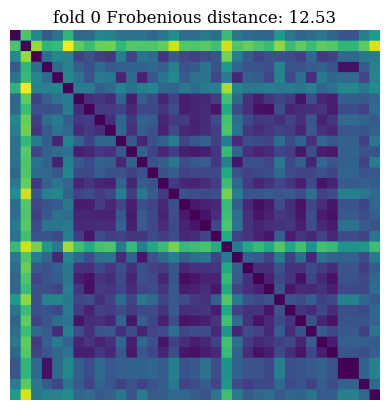

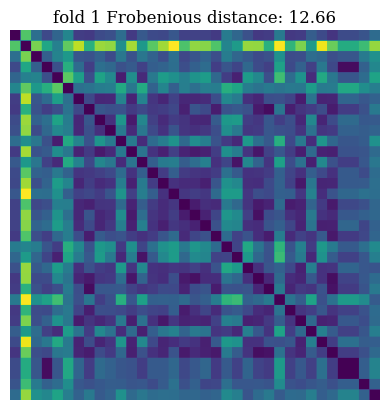

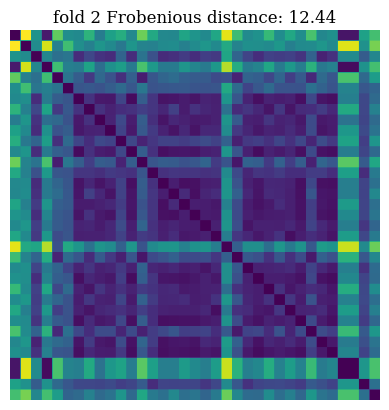

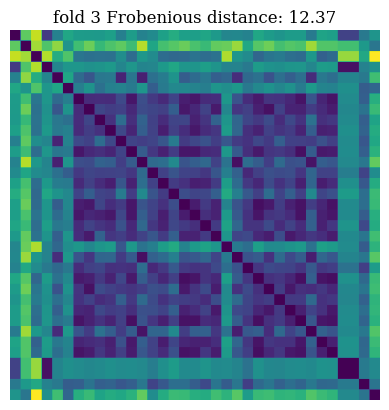

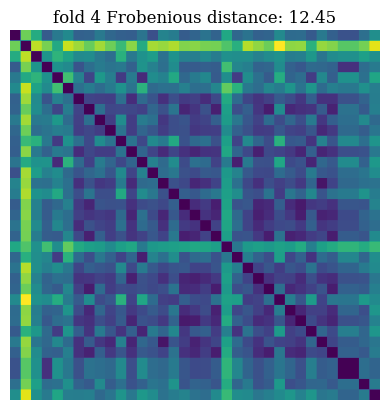

In [10]:
# lambda2 = 50
np.random.seed(35813)
torch.manual_seed(35813)
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

In [12]:
Dataset = "E" 

#Number of simulated subjects (overwriten if Dataset = "E") 
N_Subjects = 36

#Number of nodes for simulated brain networks (overwriten if Dataset = "E") 
N_Nodes = 35

#Number of brain views (overwriten if Dataset = "E")
N_views = 5

#Number of training epochs
N_max_epochs = 500

#Apply early stopping True/False
early_stop =  True

#Random subset size for SNL function  
random_sample_size = 10

#Number of cross validation folds
n_folds = 5

#Learning Rate for Adam optimizer
lr = 0.001

#Name of the model
model_name = "LMCI_THREE_LOSS_TEST"

#dimension of embeddings output by the first GDL layer (for each ROI)
CONV1 = 8
#dimension of embeddings output by the second GDL layer (for each ROI)
CONV2 = 8
#dimension of embeddings output by the third GDL layer (for each ROI)
CONV3 = 8

lambda1 = 200
lambda2 = 50
patience = 3

#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#
#                 Below is not to be modified manually                       #
#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#

import helper

if Dataset.lower() not in ["e", "E", "s", "S"]:
    raise ValueError("Dataset options are E or S.")
    
if (Dataset.lower() == "e"):
    X = connectivity_matrices_ad
    N_Subjects = X.shape[0]
    N_Nodes = X.shape[1]
    N_views = X.shape[3]
else:
    X = helper.create_better_simulated(N_Subjects, N_Nodes) if N_views == 4 else helper.simulate_dataset(N_Subjects, N_Nodes, N_views)


CONFIG = {
        "X": X,
        "N_ROIs":  X.shape[1],
        "N_views":  X.shape[3],
        "N_max_epochs": N_max_epochs,
        "n_folds": n_folds,
        "random_sample_size": random_sample_size,
        "early_stop": early_stop,
        "model_name": model_name
    }

MODEL_PARAMS = {
        "N_ROIs": N_Nodes,
        "learning_rate" : lr,
        "n_attr": X.shape[3],
        "Linear1" : {"in": N_views, "out": CONV1},
        "conv1": {"in" : 1, "out": CONV1},
        
        "Linear2" : {"in": N_views, "out": CONV1*CONV2},
        "conv2": {"in" : CONV1, "out": CONV2},
        
        "Linear3" : {"in": N_views, "out": CONV2*CONV3},
        "conv3": {"in" : CONV2, "out": CONV3},
        "lambda1" : lambda1,
        "lambda2" : lambda2,
        "patience" : patience,
    }

********* FOLD 0 *********
Epoch: 0  |  cbt loss : 34.98 | reservoir loss : 0.0931 | bio loss : 0.39073 | total loss: 73.13 | median cbt mc 10.25 | Time Elapsed: 8.12 | 
Epoch: 10  |  cbt loss : 25.34 | reservoir loss : 0.0922 | bio loss : 0.40031 | total loss: 63.79 | median cbt mc 10.25 | Time Elapsed: 9.17 | 
Epoch: 20  |  cbt loss : 19.38 | reservoir loss : 0.0920 | bio loss : 0.41512 | total loss: 58.53 | median cbt mc 10.26 | Time Elapsed: 9.18 | 
Epoch: 30  |  cbt loss : 16.02 | reservoir loss : 0.0919 | bio loss : 0.40989 | total loss: 54.89 | median cbt mc 10.26 | Time Elapsed: 9.14 | 
Epoch: 40  |  cbt loss : 14.36 | reservoir loss : 0.0919 | bio loss : 0.43469 | total loss: 54.46 | median cbt mc 10.26 | Time Elapsed: 8.64 | 
Epoch: 50  |  cbt loss : 13.46 | reservoir loss : 0.0918 | bio loss : 0.40487 | total loss: 52.08 | median cbt mc 10.26 | Time Elapsed: 8.57 | 
Epoch: 60  |  cbt loss : 13.04 | reservoir loss : 0.0918 | bio loss : 0.39302 | total loss: 51.06 | median cbt

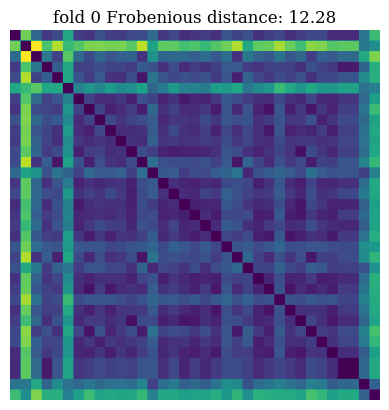

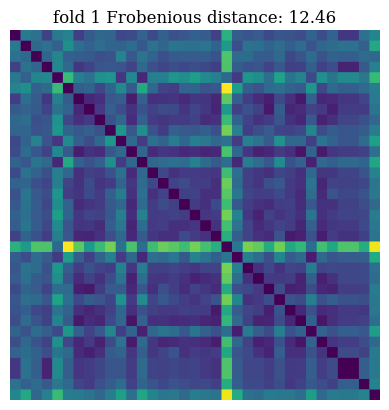

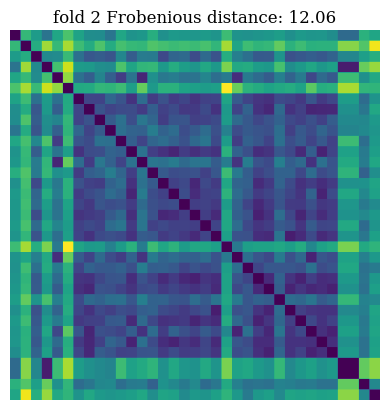

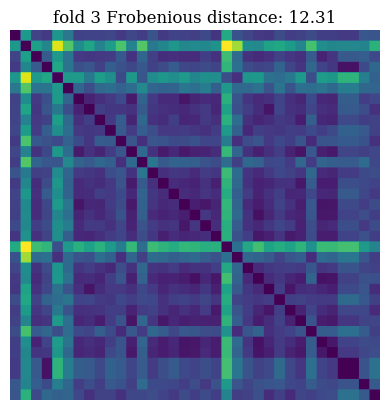

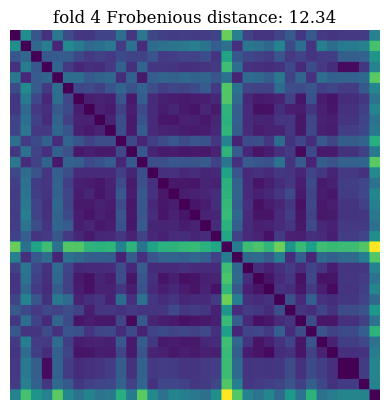

In [13]:
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])